#Problem 1 - Approximate Nearest Neighbors (25 points)

Given a dataset of vectors in a high-dimensional space, implement and analyze an Approximate Nearest Neighbors (ANN) solution using the Hierarchical Navigable Small World (HNSW) approach.

**Note #1**: Use the following test parameters:
- Number of vectors: 100
- Dimension: 2
- M-nearest neighbors: 2
- Test with query vector [0.5, 0.5]

**Required Libraries**: numpy, networkx, matplotlib

**Note #2**: Submit your code with clear documentation and visualizations of the graph structure and search process.


### (10 points) Task (a):

Implement a function `construct_HNSW(vectors, m_neighbors)` that builds a hierarchical
graph structure where:

- `vectors` is a numpy array of shape (n_vectors, dimension)
- `m_neighbors` is the number of nearest neighbors to connect in each layer
- Return a list of networkx graphs representing each layer

In [207]:
#Import required libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

#Define number of vectors, dimension, m_neighbors and generate a random dataset (specs mentioned above and in the PDF)
num_vectors = 100
dim = 2
m_neighbors = 2
vectors = np.random.rand(num_vectors, dim)
query_vec = [0.5, 0.5]

#### HNSW Construction

In [209]:
#Define the function construct_HNSW

def find_nearest_neighbors(layer, node_id, k):
    # Get distances of all nodes in the layer from node node_id
    node_pos = layer.nodes[node_id]['pos']
    distances = [(np.linalg.norm(node_pos - layer.nodes[n]['pos']), n) for n in layer.nodes if n != node_id]
    # Sort the distances in increasing order
    distances.sort(key=lambda x: x[0])

    # Return ids for the top k nodes closest to node_id
    return [neighbor for _, neighbor in distances[:k]]

#Implement the function with the dataset
def construct_HNSW(vectors, m_neighbors):
    # Initialize the number of layers in the HNSW network
    num_layers = 7

    # Create a list of graphs, one for each layer
    graphs = [nx.Graph() for _ in range(num_layers)]

    # Add all the vectors as nodes to layer 0
    for i, vector in enumerate(vectors):
        graphs[0].add_node(i, pos=vector)

    # Assign a max_layer attribute to each node in the bottom layer such that around 1/e of nodes will be at layer <= 1, around 1/(e^2) of nodes will be at layer <= 2, etc.
    mL = 1.0 / np.log(m_neighbors)
    for i in range(len(vectors)):
        u = random.random()
        max_layer = int(np.floor(-np.log(u) * mL))
        graphs[0].nodes[i]['max_layer'] = min(max_layer, num_layers - 1)

    # Add nodes and edges in all layers
    for i in range(len(vectors)):
        max_layer = graphs[0].nodes[i]['max_layer']

        # Add the node to all layers up to its max_layer
        for layer_ind in range(1, max_layer + 1):
            graphs[layer_ind].add_node(i, pos=vectors[i], max_layer=max_layer)
        
        # Create edges in each layer for this node
        for layer_ind in range(max_layer + 1):
            if i in graphs[layer_ind]:
                # Find m nearest neighbors within the current layer
                neighbors = find_nearest_neighbors(graphs[layer_ind], i, m_neighbors)
                # Add an edge between node i and m nearest neighbors within the current layer
                for neighbor in neighbors:
                    graphs[layer_ind].add_edge(i, neighbor)
    return graphs
    
graph_layers = construct_HNSW(vectors, m_neighbors)

### (8 points) Task (b):

Implement a function `search_HNSW(graph_layers, query)` that performs approximate nearest neighbor search. Your function should:

- Accept the graph layers from `construct HNSW` and a query vector
- Return the nearest neighbor found and the search path taken
- Use the layer-wise search strategy discussed in class

In [211]:
#Your code here of the implementation

# helper function to calculate euclidean distance between two vectors
def euclidean_dist(a, b):
    return np.linalg.norm(a - b)

def search_HNSW(graph_layers, query):
    num_layers = len(graph_layers)
    lastLayerInd = num_layers - 1
    lastLayer = graph_layers[lastLayerInd]
    # select a random node from last layer as starting point
    while len(list(lastLayer.nodes())) <= 0:
        lastLayerInd -= 1
        lastLayer = graph_layers[lastLayerInd]
    start_id = random.choice(list(lastLayer.nodes()))
    # initialize the path with just the starting point node
    path = [(num_layers - 1, vectors[start_id])]

    # iterate through each layer from top to bottom
    for layer in range(lastLayerInd, -1, -1):
        current_id = start_id
        changed = True
        # keep moving to closer neighbors until current_id is the closest node to query in the layer
        while changed:
            changed = False
            currDist = euclidean_dist(vectors[current_id], query)
            # iterate through neighbors of current
            for neighbor in graph_layers[layer].neighbors(current_id):
                # if any neighbor is closer to query move from current to neighbor and append current node to the path
                if euclidean_dist(vectors[neighbor], query) < currDist:
                    current_id = neighbor
                    path.append((layer, vectors[current_id]))
                    changed = True
        # set the start node to closest node to query in this layer before starting nearest neighbors search in next layer 
        start_id = current_id

    # return resultant path to closest node and the closest node's vector
    return path, vectors[start_id]
    
(search_path, nearest_neighbor) = search_HNSW(graph_layers, query)
#print("Path: " + str(search_path))
#print("Nearest Neighbor: " + str(nearest_neighbor))

Path: [(6, array([0.64582232, 0.43633695])), (5, array([0.55568291, 0.48706499])), (5, array([0.53743626, 0.6041269 ])), (5, array([0.55568291, 0.48706499]))]
Nearest Neighbor: [0.55568291 0.48706499]


###(7 points) Task (c):

Evaluate your implementation by:

- Comparing results against brute force search for a dataset of 100 vectors in 2D space
- Measuring and reporting search time for both methods
- Visualizing one example search path through the layers
- Calculating and reporting the accuracy of your approximate solution

### Brute Force

In [215]:
# Implement brute force search
def nearest_neighbor_brute_force(vectors, query):
    closest_dist = float("inf")
    closest_id = -1

    # Loop through every single vector in vectors and compare each vector to query
    for i, vec in enumerate(vectors):
        dist = euclidean_dist(vec, query)
        # Update closest_dist and closest_id if current vector distance to query < closest_dist
        if dist < closest_dist:
            closest_dist = dist
            closest_id = i
    # Return vector that is closest to query
    return vectors[closest_id]
ans = nearest_neighbor_brute_force(vectors, query)
#print(ans)

[0.55568291 0.48706499]


#### Measure and compare search times in these two cases

In [217]:
#YOUR CODE/OUTPUTS HERE

# Measure search time for brute force nearest neighbor search and display true nearest neighbor answer
start = time.time()
true_ans = nearest_neighbor_brute_force(vectors, query)
end = time.time()
total_time = end - start
print("Brute Force Nearest Neighbor Search Total Time: " + str(total_time) + " Seconds")
print("Answer: " + str(true_ans))
print()

# Construct HNSW network
graph_layers = construct_HNSW(vectors, m_neighbors)

# Measure search time for hnsw nearest neighbor search and display approximate nearest neighbor answer
start = time.time()
(search_path, approximate_nearest_neighbor) = search_HNSW(graph_layers, query)
end = time.time()
total_time = end - start
print("Hierarchical Navigable Small World Approximate Nearest Neighbor Search Total Time: " + str(total_time) + " Seconds")
print("Answer: " + str(approximate_nearest_neighbor))


Brute Force Nearest Neighbor Search Total Time: 0.0038361549377441406 Seconds
Answer: [0.55568291 0.48706499]

Hierarchical Navigable Small World Approximate Nearest Neighbor Search Total Time: 0.0005290508270263672 Seconds
Answer: [0.55568291 0.48706499]


#### Visualize one example search path

Query is represented as a red x
Vector data points are represented by blue dots
Visualization For Example Search Path: [(6, array([0.70885531, 0.01645161])), (6, array([0.09030545, 0.48911854])), (6, array([0.38913044, 0.24339891])), (2, array([0.43440611, 0.24974109])), (1, array([0.53222012, 0.40315244])), (0, array([0.55568291, 0.48706499])), (0, array([0.45815364, 0.42661584])), (0, array([0.55568291, 0.48706499]))]


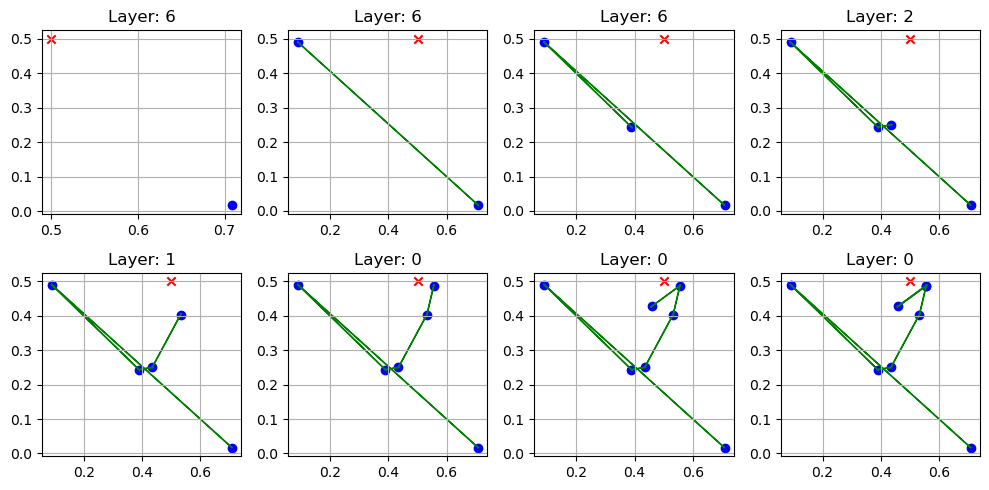

In [219]:
# YOUR CODE HERE
graph_layers = construct_HNSW(vectors, m_neighbors)
(path, nearest_neighbor) = search_HNSW(graph_layers, query)
num_layers = len(graph_layers)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i >= len(path):
        break
    layer = path[i][0]
    ax.set_title("Layer: " + str(layer))
    ax.scatter(*query, color='red', marker='x', label='Query')

    coords = []
    for j in range(i + 1):
        vec = path[j][1]
        coords.append(vec)
        ax.scatter(*vec, color='blue')
    for j in range(len(coords) - 1):
        ax.arrow(coords[j][0], coords[j][1], coords[j+1][0] - coords[j][0], coords[j+1][1] - coords[j][1], color='green')
        
    ax.grid(True)

print("Query is represented as a red x")
print("Vector data points are represented by blue dots")
print("Visualization For Example Search Path: " + str(path))
plt.tight_layout()
plt.show()

#### Calculate and report accuracy of approximate search case

In [221]:
# Your code here
def evaluate_accuracy(graph_layers, vectors, queries):
    correct = 0
    for q in queries:
        _, approx = search_HNSW(graph_layers, q)
        true = nearest_neighbor_brute_force(vectors, q)
        if np.array_equal(approx, true):
            correct += 1
    return correct / len(queries)

graph_layers = construct_HNSW(vectors, m_neighbors)
queries = []
for _ in range(500000):
    random_array = np.random.rand(1, 2)
    queries.append(random_array)

# Evaluated the accuracy of Hierarchical Navigable Small World Approximate Nearest Neighbor Search on 500000 random queries
print("Resultant Accuracy of Hierarchical Navigable Small World Approximate Nearest Neighbor Search on 500000 random queries: " + str(evaluate_accuracy(graph_layers, vectors, queries)))

Resultant Accuracy of Hierarchical Navigable Small World Approximate Nearest Neighbor Search on 500000 random queries: 0.656258


# Problem 1 Bonus:

- (+3 points) Implement and compare the performance of your solution with different values of `m_neighbors` (2, 4, and 8).
- (+2 points) Test your algorithm on a real dataset embedding (like Wikipedia) and report your results.
